<a href="https://colab.research.google.com/github/juoll/data_analyst_test_technique/blob/main/notebooks/DTAM-807/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyDrive kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from kneed import KneeLocator
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
import numpy as np
import warnings
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer


In [ ]:
def get_id_if_exist(folder_id, file_name):
  file_list = drive.ListFile({'q':"'"+ folder_id +"'  in parents and trashed=False"}).GetList()
  for x in range(len(file_list)):
    if file_list[x]['title'] == file_name:
      return file_list[x]['id']

In [ ]:
def create_gfile(folder_id, filename):
  existing_id = get_id_if_exist(folder_id, filename)
  if existing_id:
      return drive.CreateFile({'id':existing_id})
  else:
      return drive.CreateFile({'parents': [{'id': folder_id}]})

In [ ]:
def plot_elbow(col_name):
  print('Elbow Method to determine the number of clusters to be formed:')
  Elbow_M = KElbowVisualizer(KMeans(), k=10)
  Elbow_M.fit(X[X[col_name].notnull()][[col_name]])
  Elbow_M.show()

In [ ]:
class GeoClusterTransformer(BaseEstimator, TransformerMixin):
  epsilon = None
  lat_col = None
  lon_col = None
  min_samples = None

  def __init__(self, lat_col, lon_col, min_samples, epsilon):
    self.lat_col = lat_col
    self.lon_col = lon_col
    self.min_samples = min_samples
    if epsilon:
      self.epsilon=epsilon
      
  
  def dbscan_cluster(self, latitudes,longitudes,epsilon,min_samples,**kwargs):
    '''
    Function to perform DBSCAN clustering for given parameters.
    
    '''
    
    # convert epsilon from km to radians
    kms_per_radian = 6371.0088
    epsilon /= kms_per_radian
    
    # set up the algorithm
    dbscan = DBSCAN(
        eps = epsilon,
        min_samples = min_samples,
        algorithm = 'ball_tree',
        metric = 'haversine',
        **kwargs
    )
    
    # fit the algorithm
    return dbscan.fit(
        np.radians(
            [x for x in zip(latitudes,longitudes)]
        )
    )

  def compute_epsilon(self, X):
    n=5
    
    # n_neighbors as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
    nbrs = NearestNeighbors(n_neighbors = n, algorithm = 'ball_tree', metric = 'haversine').fit(np.radians(
                [x for x in zip(X[:,0], X[:,1])]
            ))
    neigh_dist, neigh_ind = nbrs.kneighbors(np.radians(
                [x for x in zip(X[:,0], X[:,1])]
            ))
    # sort the neighbor distances (lengths to points) in ascending order
    # axis = 0 represents sort along first axis i.e. sort along row
    sort_neigh_dist = np.sort(neigh_dist, axis = 0)
    k_dist = sort_neigh_dist[:, n-1]
    k_dist=[x * 6371000/1000 for x in k_dist]
    kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                          curve = "concave", direction = "increasing", online=True)

    # get the estimate of knee point

    return kneedle.knee_y

  def get_feature_names_out(self):
        pass

  def fit(self, X, y=None):
      X_geo = np.array(X[[self.lat_col,self.lon_col]])
      if self.epsilon is None:
        self.epsilon = self.compute_epsilon(X_geo)
      print(self.epsilon)
      return self

  def transform(self, X, y=None):
      X_geo = np.array(X[[self.lat_col,self.lon_col]])
      self.clusters = self.dbscan_cluster(X_geo[:,0], X_geo[:,1], self.epsilon, self.min_samples)
      set(self.clusters.labels_)
      X_res=X.copy()
      X_res['GEO_CLUSTER'] = self.clusters.labels_

      return X_res[['GEO_CLUSTER']]

In [ ]:
class CustomkBinsTransformer(BaseEstimator, TransformerMixin):

  col_name=None
  k=None

  def __init__(self, col_name, k):
    self.col_name=col_name
    self.k=k

  def get_feature_names_out(self):
        pass

  def fit(self, X, y=None):
    return self

  def CustomkBinsDiscretizer(self, serie, n_bins=4, encode='ordinal', strategy='kmeans'):

    # set valid mask
    X=serie.to_numpy()
    nan_mask = np.isnan(X)
    valid_mask = ~nan_mask

    kBinsDiscretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')

    # create a result array
    Xt = np.full(X.shape, np.nan)

    # assign only valid cases to 
    Xt[valid_mask] = kBinsDiscretizer.fit_transform(X[valid_mask].reshape(-1,1)).reshape(X[valid_mask].shape)
    Xt=np.nan_to_num(Xt, nan=-1)
    np.unique(Xt)

    return Xt.tolist()

  def transform(self, X, y=None):
    return self.CustomkBinsDiscretizer(X[self.col_name], n_bins=self.k)



In [ ]:
# paramétrage
pd.options.display.max_columns = None
pd.options.display.width = 1000
pd.options.display.max_seq_items = None
warnings.filterwarnings('ignore')

In [ ]:
def downcast(data):
    for col in data.columns:
        if data[col].dtype == "int64":
            data[col] = pd.to_numeric(data[col], downcast="integer")
        if data[col].dtype == "float64":
            data[col] = pd.to_numeric(data[col], downcast="float")

In [ ]:
# Authentification et instantitaion client google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Récupération du CSV depuis le drive
dl = drive.CreateFile({'id':'1NiqywXD1rRCGca-pVp_jWKZ1M0tsQUxF'}) 
dl.GetContentFile('clean-dataset.csv')  
df = pd.read_csv('clean-dataset.csv')

In [ ]:
df.columns

Index(['ENT_LIC', 'ENT_AGE_EDITION', 'ENT_TYPE_CAP', 'ENT_REG_FISC', 'ENT_REG_IMP', 'ENT_FORM_JUR', 'ENT_TYPE_TVA', 'ENT_ACT_TVA', 'ENT_REG_TVA', 'ENT_TYPE_COMPTA', 'ENT_TYPE_PACK_LIC', 'ENT_SECT_ACT', 'ENT_AGE_MEG', 'ENT_EFFECTIF', 'ENT_CAT_ENT', 'ENT_ETAT_ADM', 'ENT_CAR_EMP', 'ENT_SEC_NAF', 'ENT_LAT', 'ENT_LON', 'ENT_CAT_JUR_NIV1', 'CAB_AGE_MEG', 'CAB_TYPE_ACT', 'CAB_HAS_PERSO', 'CAB_SITE_ORGA', 'CAB_NB_SOUS_SITES', 'CAB_NB_PREM_DIS', 'CAB_MT_PREM_HONO', 'CAB_AGE_CAB', 'CAB_EFFECTIF', 'CAB_CAT_ENT', 'CAB_ETAT_ADM', 'CAB_CAR_EMP', 'CAB_SEC_NAF', 'CAB_DIV_NAF', 'CAB_LAT', 'CAB_LON', 'CAB_CAT_JUR_NIV2', 'NB_HITS_ACH', 'NB_HITS_EXP', 'NB_HITS_NDF', 'NB_HITS_TDB', 'NB_HITS_FAC', 'NB_HITS_CAI', 'NB_HITS_BAT', 'NB_COMMANDES_SUR_2_ANS', 'AGE_SINCE_FIRST_PACK', 'AGE_SINCE_SECOND_PACK', 'AGE_SINCE_LAST_PACK', 'TAUX_AFFECTATION'], dtype='object')

In [ ]:
df.head(5)

,ENT_LIC,ENT_AGE_EDITION,ENT_TYPE_CAP,ENT_REG_FISC,ENT_REG_IMP,ENT_FORM_JUR,ENT_TYPE_TVA,ENT_ACT_TVA,ENT_REG_TVA,ENT_TYPE_COMPTA,ENT_TYPE_PACK_LIC,ENT_SECT_ACT,ENT_AGE_MEG,ENT_EFFECTIF,ENT_CAT_ENT,ENT_ETAT_ADM,ENT_CAR_EMP,ENT_SEC_NAF,ENT_LAT,ENT_LON,ENT_CAT_JUR_NIV1,CAB_AGE_MEG,CAB_TYPE_ACT,CAB_HAS_PERSO,CAB_SITE_ORGA,CAB_NB_SOUS_SITES,CAB_NB_PREM_DIS,CAB_MT_PREM_HONO,CAB_AGE_CAB,CAB_EFFECTIF,CAB_CAT_ENT,CAB_ETAT_ADM,CAB_CAR_EMP,CAB_SEC_NAF,CAB_DIV_NAF,CAB_LAT,CAB_LON,CAB_CAT_JUR_NIV2,NB_HITS_ACH,NB_HITS_EXP,NB_HITS_NDF,NB_HITS_TDB,NB_HITS_FAC,NB_HITS_CAI,NB_HITS_BAT,NB_COMMANDES_SUR_2_ANS,AGE_SINCE_FIRST_PACK,AGE_SINCE_SECOND_PACK,AGE_SINCE_LAST_PACK,TAUX_AFFECTATION
0,PREMIUM,2,SOCIAL,BNC,IR,EI,ENCAISSEMENT,PRESTATION_SERVICES,SIMPLIFIE_ANNUELLE,TRESORERIE,PACK_10,SERVICES,62,NN,PME,A,O,P,48.177082,-1.741313,1.0,133,EXPERT_COMPTABLE,False,False,0,37,335.0,206,12,PME,A,O,M,69.0,48.152676,-1.777329,54.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,63.838710,62.967743,23.612904,0.891892
1,FREE,2,SOCIAL,BIC,IR,EI,ENCAISSEMENT,PRESTATION_SERVICES,NORMAL_TRIMESTRIELLE,ENGAGEMENT,PACK_10,SERVICES,58,NN,PME,A,N,L,47.108147,6.687952,1.0,125,EXPERT_COMPTABLE,False,False,47,24,225.0,386,NN,ETI,C,N,M,69.0,45.770996,4.889071,55.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,1.0,87.096770,75.774190,16.870968,0.500000
2,FREE,6,SOCIAL,BIC,IS,SA,ENCAISSEMENT,PRESTATION_SERVICES,NORMAL_MENSUELLE,ENGAGEMENT,PACK_10,AUTRE,56,11,PME,C,O,J,48.780250,2.259809,5.0,123,EXPERT_COMPTABLE,True,False,0,16,200.0,129,NN,PME,A,N,M,69.0,48.872726,2.312558,57.0,0.0,6.0,0.0,0.0,92.0,0.0,0.0,0.0,87.096770,71.645164,32.838710,0.812500
3,FREE,3,SOCIAL,BIC,IR,CUMA,ENCAISSEMENT,PRESTATION_SERVICES,SIMPLIFIE_ANNUELLE,ENGAGEMENT,PACK_10,SERVICES,9,01,PME,A,N,N,48.399918,-2.389070,6.0,80,EXPERT_COMPTABLE,False,False,1,6,50.0,554,32,ETI,A,O,M,69.0,48.543995,-2.769716,92.0,0.0,2.0,0.0,0.0,259.0,0.0,0.0,0.0,79.548386,NaN,79.548386,0.333333
4,FREE,0,SOCIAL,BIC,IS,SARL,ENCAISSEMENT,PRESTATION_SERVICES,NORMAL_MENSUELLE,ENGAGEMENT,PACK_10,SERVICES,84,02,PME,A,O,M,43.136536,5.932599,5.0,131,EXPERT_COMPTABLE,False,False,2,0,0.0,359,02,PME,A,O,M,69.0,43.136536,5.932599,54.0,0.0,4.0,0.0,0.0,1474.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
X=df.copy()
len(X)


45701

In [ ]:
X=X[(df.ENT_AGE_EDITION <= 12) & (df.ENT_LON.notnull()) & (df.ENT_LAT.notnull())]

In [ ]:
len(X)

44875

# 🟨 Discretizing

> Discretizing is the process of turning continuous data into discrete data using bins.
- 🧪 Performs feature engineering
- 🎯 Turns a regression task into a classification task


📚 Pandas cut() documentation

In [ ]:
X.columns

Index(['ENT_LIC', 'ENT_AGE_EDITION', 'ENT_TYPE_CAP', 'ENT_REG_FISC', 'ENT_REG_IMP', 'ENT_FORM_JUR', 'ENT_TYPE_TVA', 'ENT_ACT_TVA', 'ENT_REG_TVA', 'ENT_TYPE_COMPTA', 'ENT_TYPE_PACK_LIC', 'ENT_SECT_ACT', 'ENT_AGE_MEG', 'ENT_EFFECTIF', 'ENT_CAT_ENT', 'ENT_ETAT_ADM', 'ENT_CAR_EMP', 'ENT_SEC_NAF', 'ENT_LAT', 'ENT_LON', 'ENT_CAT_JUR_NIV1', 'CAB_AGE_MEG', 'CAB_TYPE_ACT', 'CAB_HAS_PERSO', 'CAB_SITE_ORGA', 'CAB_NB_SOUS_SITES', 'CAB_NB_PREM_DIS', 'CAB_MT_PREM_HONO', 'CAB_AGE_CAB', 'CAB_EFFECTIF', 'CAB_CAT_ENT', 'CAB_ETAT_ADM', 'CAB_CAR_EMP', 'CAB_SEC_NAF', 'CAB_DIV_NAF', 'CAB_LAT', 'CAB_LON', 'CAB_CAT_JUR_NIV2', 'NB_HITS_ACH', 'NB_HITS_EXP', 'NB_HITS_NDF', 'NB_HITS_TDB', 'NB_HITS_FAC', 'NB_HITS_CAI', 'NB_HITS_BAT', 'NB_COMMANDES_SUR_2_ANS', 'AGE_SINCE_FIRST_PACK', 'AGE_SINCE_SECOND_PACK', 'AGE_SINCE_LAST_PACK', 'TAUX_AFFECTATION'], dtype='object')

Elbow Method to determine the number of clusters to be formed:


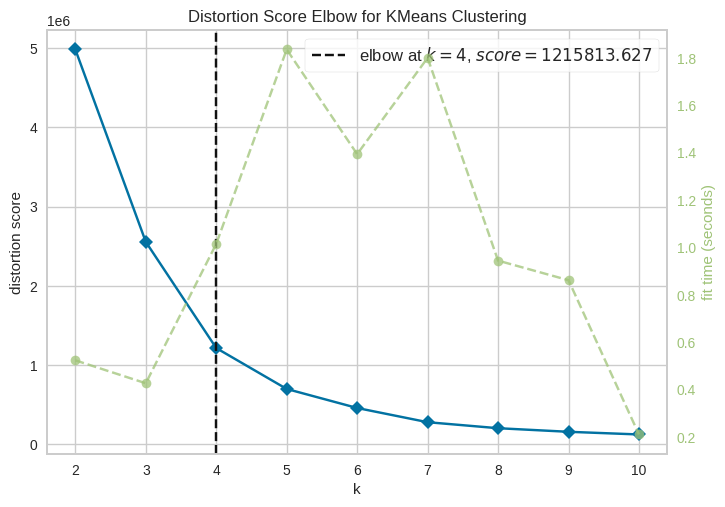

In [ ]:
plot_elbow('AGE_SINCE_FIRST_PACK')

In [ ]:
preproc_cat_age_since_first_pack = make_pipeline(
    CustomkBinsTransformer('AGE_SINCE_FIRST_PACK', 4)
)

Elbow Method to determine the number of clusters to be formed:


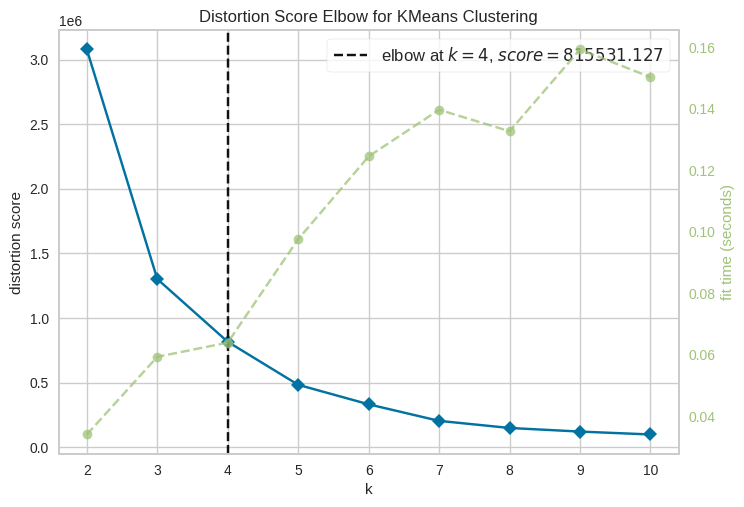

In [ ]:
plot_elbow('AGE_SINCE_SECOND_PACK')

In [ ]:
preproc_cat_age_since_second_pack = make_pipeline(
    CustomkBinsTransformer('AGE_SINCE_SECOND_PACK', 4)
)

Elbow Method to determine the number of clusters to be formed:


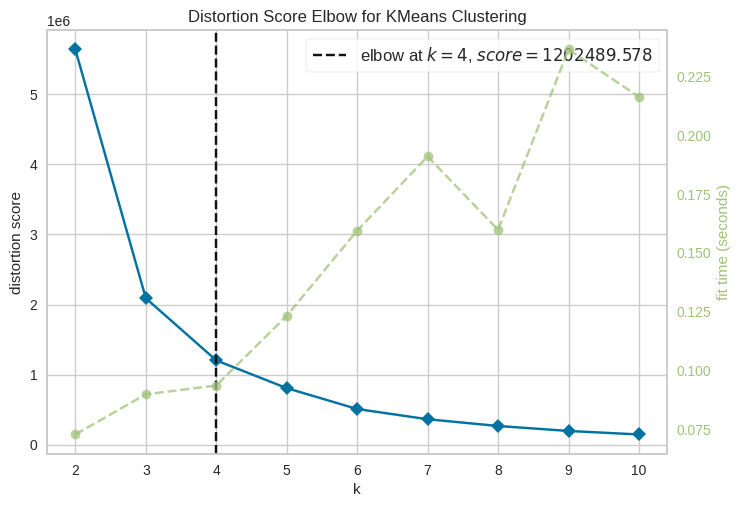

In [ ]:
plot_elbow('AGE_SINCE_LAST_PACK')

In [ ]:
preproc_cat_age_since_last_pack = make_pipeline(
    CustomkBinsTransformer('AGE_SINCE_LAST_PACK', 4)
)

Elbow Method to determine the number of clusters to be formed:


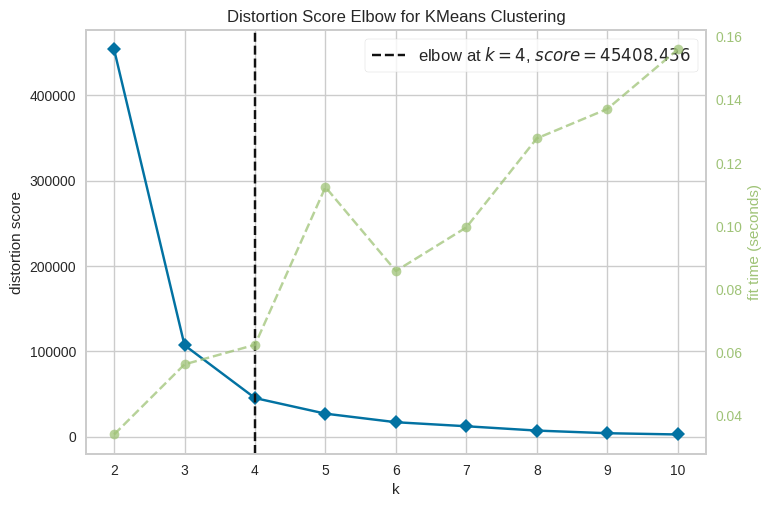

In [ ]:
plot_elbow('NB_COMMANDES_SUR_2_ANS')

In [ ]:
preproc_cat_nb_commandes_sur_2_ans = make_pipeline(
    CustomkBinsTransformer('NB_COMMANDES_SUR_2_ANS', 4)
)

Elbow Method to determine the number of clusters to be formed:


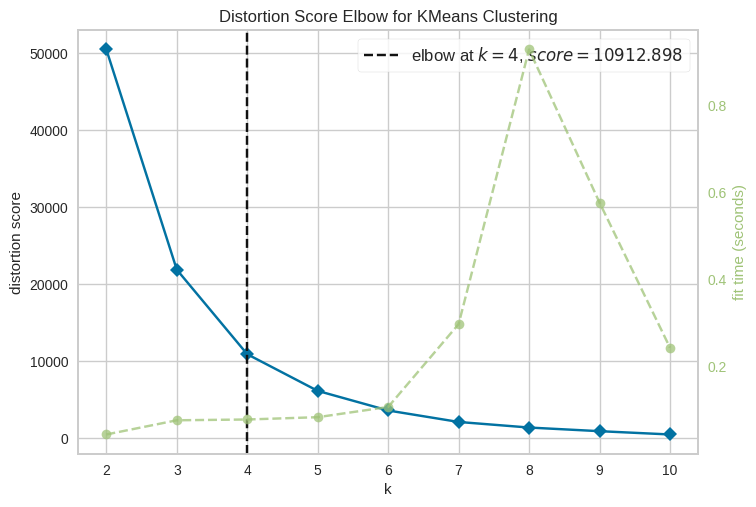

In [ ]:
plot_elbow('ENT_AGE_EDITION')

In [ ]:
preproc_cat_ent_age_edition = make_pipeline(
    CustomkBinsTransformer('ENT_AGE_EDITION', 4)
)

Elbow Method to determine the number of clusters to be formed:


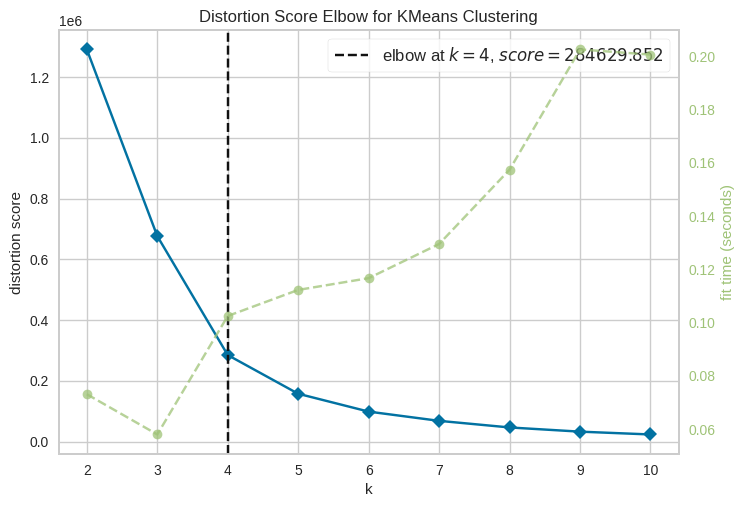

In [ ]:
plot_elbow('CAB_NB_SOUS_SITES')

In [ ]:
preproc_cat_bn_ss_sites = make_pipeline(
    CustomkBinsTransformer('CAB_NB_SOUS_SITES', 4)
)

Elbow Method to determine the number of clusters to be formed:


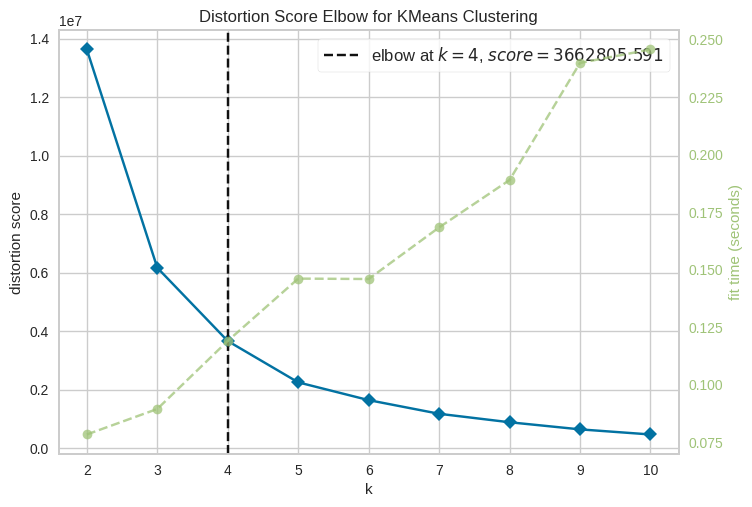

In [ ]:
plot_elbow('CAB_AGE_MEG')

In [ ]:
preproc_cat_cab_age_meg = make_pipeline(
    CustomkBinsTransformer('CAB_AGE_MEG', 4)
)

Elbow Method to determine the number of clusters to be formed:


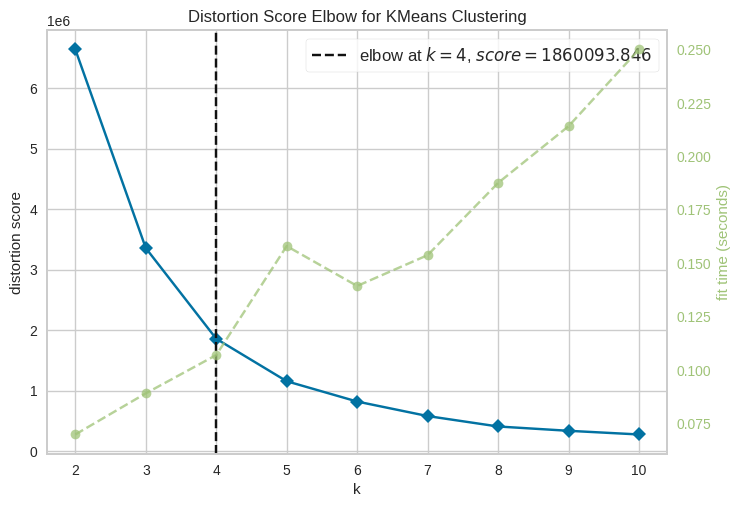

In [ ]:
plot_elbow('ENT_AGE_MEG')

In [ ]:
preproc_cat_ent_age_meg = make_pipeline(
    CustomkBinsTransformer('ENT_AGE_MEG', 4)
)

In [ ]:
feature_discretizing = ColumnTransformer([
   ('cat_ord_age_since_first_pack_tr', preproc_cat_age_since_first_pack, ['AGE_SINCE_FIRST_PACK']),
   ('cat_ord_age_since_second_pack_tr', preproc_cat_age_since_second_pack, ['AGE_SINCE_SECOND_PACK']),
   ('cat_ord_age_since_last_pack_tr', preproc_cat_age_since_last_pack, ['AGE_SINCE_LAST_PACK']),
   ('cat_ord_nb_commandes_sur_2_ans_tr', preproc_cat_nb_commandes_sur_2_ans, ['NB_COMMANDES_SUR_2_ANS']),
   ('cat_ord_ent_age_edition_tr', preproc_cat_ent_age_edition, ['ENT_AGE_EDITION']),
   ('cat_ord_nb_ss_sites', preproc_cat_bn_ss_sites, ['CAB_NB_SOUS_SITES']),
   ('cat_ord_cab_age_meg', preproc_cat_cab_age_meg, ['CAB_AGE_MEG']),
   ('cat_ord_ent_age_meg', preproc_cat_ent_age_meg, ['ENT_AGE_MEG']),
])

feature_discretizing

ColumnTransformer(transformers=[('cat_ord_age_since_first_pack_tr',
                                 Pipeline(steps=[('customkbinstransformer',
                                                  CustomkBinsTransformer(col_name='AGE_SINCE_FIRST_PACK',
                                                                         k=4))]),
                                 ['AGE_SINCE_FIRST_PACK']),
                                ('cat_ord_age_since_second_pack_tr',
                                 Pipeline(steps=[('customkbinstransformer',
                                                  CustomkBinsTransformer(col_name='AGE_SINCE_SECOND_PACK',
                                                                         k=4))]),
                                 ['AGE_SINC...
                                                  CustomkBinsTransformer(col_name='CAB_NB_SOUS_SITES',
                                                                         k=4))]),
                                 ['CAB_NB_SOUS_SITES']),
                                ('cat_ord_cab_age_meg',
                                 Pipeline(steps=[('customkbinstransformer',
                                                  CustomkBinsTransformer(col_name='CAB_AGE_MEG',
                                                                         k=4))]),
                                 ['CAB_AGE_MEG']),
                                ('cat_ord_ent_age_meg',
                                 Pipeline(steps=[('customkbinstransformer',
                                                  CustomkBinsTransformer(col_name='ENT_AGE_MEG',
                                                                         k=4))]),
                                 ['ENT_AGE_MEG'])])

In [ ]:
feature_discretizing.set_output(transform="pandas")
features_transformed = feature_discretizing.fit_transform(X)
features_transformed.head(5)

,cat_ord_age_since_first_pack_tr__0,cat_ord_age_since_second_pack_tr__0,cat_ord_age_since_last_pack_tr__0,cat_ord_nb_commandes_sur_2_ans_tr__0,cat_ord_ent_age_edition_tr__0,cat_ord_nb_ss_sites__0,cat_ord_cab_age_meg__0,cat_ord_ent_age_meg__0
0,2.0,2.0,1.0,0.0,0.0,0.0,3.0,2.0
1,3.0,3.0,0.0,0.0,0.0,2.0,3.0,2.0
2,3.0,3.0,1.0,0.0,2.0,0.0,3.0,2.0
3,3.0,-1.0,3.0,0.0,1.0,0.0,1.0,0.0
4,-1.0,-1.0,-1.0,-1.0,0.0,0.0,3.0,3.0


In [ ]:
X['CAT_AGE_SINCE_FIRST_PACK']=features_transformed['cat_ord_age_since_first_pack_tr__0']
X['CAT_AGE_SINCE_SECOND_PACK']=features_transformed['cat_ord_age_since_second_pack_tr__0']
X['CAT_AGE_SINCE_LAST_PACK']=features_transformed['cat_ord_age_since_last_pack_tr__0']
X['CAT_NB_COMMANDES_SUR_2_ANS']=features_transformed['cat_ord_nb_commandes_sur_2_ans_tr__0']
X['CAT_ENT_AGE_EDITION']=features_transformed['cat_ord_ent_age_edition_tr__0']

In [ ]:
X.drop(columns=['AGE_SINCE_FIRST_PACK', 'AGE_SINCE_SECOND_PACK', 'AGE_SINCE_LAST_PACK', 'NB_COMMANDES_SUR_2_ANS', 'CAB_AGE_MEG', 'ENT_AGE_EDITION', 'CAB_NB_SOUS_SITES', 'ENT_AGE_MEG'], inplace=True)

# 🟨 Feature creation

🧑🏻‍🔬 We can introduce some domain knowledge into a dataset in order to drive more signals for our models to learn!

Why create new features?
- ➕ Create additional information
- 📈 Potentially improve model performance

In [ ]:
feat_ent_geo = ['ENT_LAT', 'ENT_LON']

preproc_ent_geo_cluster = make_pipeline(
    GeoClusterTransformer('ENT_LAT', 'ENT_LON', 1600, None),
    #OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

feature_engineering = ColumnTransformer([
   ('ent_cluster_geo_tr', preproc_ent_geo_cluster, feat_ent_geo)
])

feature_engineering

ColumnTransformer(transformers=[('ent_cluster_geo_tr',
                                 Pipeline(steps=[('geoclustertransformer',
                                                  GeoClusterTransformer(epsilon=None,
                                                                        lat_col='ENT_LAT',
                                                                        lon_col='ENT_LON',
                                                                        min_samples=1600))]),
                                 ['ENT_LAT', 'ENT_LON'])])

In [ ]:
feature_engineering.set_output(transform="pandas")
features_transformed = feature_engineering.fit_transform(X)
X['ENT_GEO_CLUSTER']=features_transformed['ent_cluster_geo_tr__GEO_CLUSTER']
X["ENT_GEO_CLUSTER"].nunique()

71.81751025289967


7

In [ ]:
lst_elements = sorted(list(X["ENT_GEO_CLUSTER"].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
X["color"] = X["ENT_GEO_CLUSTER"].apply(lambda x: 
                lst_colors[lst_elements.index(x)])


fig = px.scatter_mapbox(X, 
                        lat="ENT_LAT", 
                        lon="ENT_LON", 
                        hover_name="ENT_GEO_CLUSTER", 
                        hover_data=["ENT_GEO_CLUSTER"],
                        color="color",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

👉 Scikit Learn has many more processing tools!

📚sklearn.preprocessing

In [ ]:
X.head(5)

,ENT_LIC,ENT_TYPE_CAP,ENT_REG_FISC,ENT_REG_IMP,ENT_FORM_JUR,ENT_TYPE_TVA,ENT_ACT_TVA,ENT_REG_TVA,ENT_TYPE_COMPTA,ENT_TYPE_PACK_LIC,ENT_SECT_ACT,ENT_EFFECTIF,ENT_CAT_ENT,ENT_ETAT_ADM,ENT_CAR_EMP,ENT_SEC_NAF,ENT_LAT,ENT_LON,ENT_CAT_JUR_NIV1,CAB_TYPE_ACT,CAB_HAS_PERSO,CAB_SITE_ORGA,CAB_NB_PREM_DIS,CAB_MT_PREM_HONO,CAB_AGE_CAB,CAB_EFFECTIF,CAB_CAT_ENT,CAB_ETAT_ADM,CAB_CAR_EMP,CAB_SEC_NAF,CAB_DIV_NAF,CAB_LAT,CAB_LON,CAB_CAT_JUR_NIV2,NB_HITS_ACH,NB_HITS_EXP,NB_HITS_NDF,NB_HITS_TDB,NB_HITS_FAC,NB_HITS_CAI,NB_HITS_BAT,TAUX_AFFECTATION,CAT_AGE_SINCE_FIRST_PACK,CAT_AGE_SINCE_SECOND_PACK,CAT_AGE_SINCE_LAST_PACK,CAT_NB_COMMANDES_SUR_2_ANS,CAT_ENT_AGE_EDITION,ENT_GEO_CLUSTER,color
0,PREMIUM,SOCIAL,BNC,IR,EI,ENCAISSEMENT,PRESTATION_SERVICES,SIMPLIFIE_ANNUELLE,TRESORERIE,PACK_10,SERVICES,NN,PME,A,O,P,48.177082,-1.741313,1.0,EXPERT_COMPTABLE,False,False,37,335.0,206,12,PME,A,O,M,69.0,48.152676,-1.777329,54.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.891892,2.0,2.0,1.0,0.0,0.0,0,#74C0E1
1,FREE,SOCIAL,BIC,IR,EI,ENCAISSEMENT,PRESTATION_SERVICES,NORMAL_TRIMESTRIELLE,ENGAGEMENT,PACK_10,SERVICES,NN,PME,A,N,L,47.108147,6.687952,1.0,EXPERT_COMPTABLE,False,False,24,225.0,386,NN,ETI,C,N,M,69.0,45.770996,4.889071,55.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.500000,3.0,3.0,0.0,0.0,0.0,-1,#3E22D9
2,FREE,SOCIAL,BIC,IS,SA,ENCAISSEMENT,PRESTATION_SERVICES,NORMAL_MENSUELLE,ENGAGEMENT,PACK_10,AUTRE,11,PME,C,O,J,48.780250,2.259809,5.0,EXPERT_COMPTABLE,True,False,16,200.0,129,NN,PME,A,N,M,69.0,48.872726,2.312558,57.0,0.0,6.0,0.0,0.0,92.0,0.0,0.0,0.812500,3.0,3.0,1.0,0.0,2.0,1,#DEC715
3,FREE,SOCIAL,BIC,IR,CUMA,ENCAISSEMENT,PRESTATION_SERVICES,SIMPLIFIE_ANNUELLE,ENGAGEMENT,PACK_10,SERVICES,01,PME,A,N,N,48.399918,-2.389070,6.0,EXPERT_COMPTABLE,False,False,6,50.0,554,32,ETI,A,O,M,69.0,48.543995,-2.769716,92.0,0.0,2.0,0.0,0.0,259.0,0.0,0.0,0.333333,3.0,-1.0,3.0,0.0,1.0,0,#74C0E1
4,FREE,SOCIAL,BIC,IS,SARL,ENCAISSEMENT,PRESTATION_SERVICES,NORMAL_MENSUELLE,ENGAGEMENT,PACK_10,SERVICES,02,PME,A,O,M,43.136536,5.932599,5.0,EXPERT_COMPTABLE,False,False,0,0.0,359,02,PME,A,O,M,69.0,43.136536,5.932599,54.0,0.0,4.0,0.0,0.0,1474.0,0.0,0.0,NaN,-1.0,-1.0,-1.0,-1.0,0.0,2,#C0BA08


In [ ]:
X.drop(columns=['ENT_LAT', 'ENT_LON'], inplace=True)

In [ ]:
X.drop(columns=['CAB_LAT', 'CAB_LON'], inplace=True)

In [ ]:
X.drop(columns=['color'], inplace=True)

In [ ]:
X.head(5)

,ENT_LIC,ENT_TYPE_CAP,ENT_REG_FISC,ENT_REG_IMP,ENT_FORM_JUR,ENT_TYPE_TVA,ENT_ACT_TVA,ENT_REG_TVA,ENT_TYPE_COMPTA,ENT_TYPE_PACK_LIC,ENT_SECT_ACT,ENT_EFFECTIF,ENT_CAT_ENT,ENT_ETAT_ADM,ENT_CAR_EMP,ENT_SEC_NAF,ENT_CAT_JUR_NIV1,CAB_TYPE_ACT,CAB_HAS_PERSO,CAB_SITE_ORGA,CAB_NB_PREM_DIS,CAB_MT_PREM_HONO,CAB_AGE_CAB,CAB_EFFECTIF,CAB_CAT_ENT,CAB_ETAT_ADM,CAB_CAR_EMP,CAB_SEC_NAF,CAB_DIV_NAF,CAB_CAT_JUR_NIV2,NB_HITS_ACH,NB_HITS_EXP,NB_HITS_NDF,NB_HITS_TDB,NB_HITS_FAC,NB_HITS_CAI,NB_HITS_BAT,TAUX_AFFECTATION,CAT_AGE_SINCE_FIRST_PACK,CAT_AGE_SINCE_SECOND_PACK,CAT_AGE_SINCE_LAST_PACK,CAT_NB_COMMANDES_SUR_2_ANS,CAT_ENT_AGE_EDITION,ENT_GEO_CLUSTER
0,PREMIUM,SOCIAL,BNC,IR,EI,ENCAISSEMENT,PRESTATION_SERVICES,SIMPLIFIE_ANNUELLE,TRESORERIE,PACK_10,SERVICES,NN,PME,A,O,P,1.0,EXPERT_COMPTABLE,False,False,37,335.0,206,12,PME,A,O,M,69.0,54.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.891892,2.0,2.0,1.0,0.0,0.0,0
1,FREE,SOCIAL,BIC,IR,EI,ENCAISSEMENT,PRESTATION_SERVICES,NORMAL_TRIMESTRIELLE,ENGAGEMENT,PACK_10,SERVICES,NN,PME,A,N,L,1.0,EXPERT_COMPTABLE,False,False,24,225.0,386,NN,ETI,C,N,M,69.0,55.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.500000,3.0,3.0,0.0,0.0,0.0,-1
2,FREE,SOCIAL,BIC,IS,SA,ENCAISSEMENT,PRESTATION_SERVICES,NORMAL_MENSUELLE,ENGAGEMENT,PACK_10,AUTRE,11,PME,C,O,J,5.0,EXPERT_COMPTABLE,True,False,16,200.0,129,NN,PME,A,N,M,69.0,57.0,0.0,6.0,0.0,0.0,92.0,0.0,0.0,0.812500,3.0,3.0,1.0,0.0,2.0,1
3,FREE,SOCIAL,BIC,IR,CUMA,ENCAISSEMENT,PRESTATION_SERVICES,SIMPLIFIE_ANNUELLE,ENGAGEMENT,PACK_10,SERVICES,01,PME,A,N,N,6.0,EXPERT_COMPTABLE,False,False,6,50.0,554,32,ETI,A,O,M,69.0,92.0,0.0,2.0,0.0,0.0,259.0,0.0,0.0,0.333333,3.0,-1.0,3.0,0.0,1.0,0
4,FREE,SOCIAL,BIC,IS,SARL,ENCAISSEMENT,PRESTATION_SERVICES,NORMAL_MENSUELLE,ENGAGEMENT,PACK_10,SERVICES,02,PME,A,O,M,5.0,EXPERT_COMPTABLE,False,False,0,0.0,359,02,PME,A,O,M,69.0,54.0,0.0,4.0,0.0,0.0,1474.0,0.0,0.0,NaN,-1.0,-1.0,-1.0,-1.0,0.0,2


In [ ]:
filename='engineered-dataset.csv'
folder_id='1Owz9_gb_1UqsLUdwvO8ShO8v6WMAApCh'

X.to_csv(filename, index=False)

gfile=create_gfile(folder_id, filename)
gfile.SetContentFile(filename)
gfile.Upload()